# Modeling Results Visualization

This notebook generates publication-quality figures for the modeling results.

## Three Figure Types:
1. **Confusion Matrix Grid**: n×m grid showing confusion matrices for selected models and strategy
2. **Accuracy Bar Plot**: Bar chart showing average accuracy for all model combinations
3. **Learning Curves**: Time series plots showing accuracy vs training windows for participant-specific models

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 13
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

## Configuration

In [2]:
# Base paths
MODEL_OUTPUT_DIR = Path("model_output")

# Feature group names (used in file names)
FEATURE_GROUPS = {
    'pose': 'Pose Features',
    'eye': 'Eye-Tracking Features',
    'performance': 'Task Performance Features',
    'gsr': 'GSR Features',
    'ecg': 'ECG Features',
    'gsr_ecg': 'GSR + ECG Features',
    'all': 'All Features'
}

# CV strategies
STRATEGIES = {
    'random': 'random_split',
    'participant': 'participant_split',
    'lopo': 'lopo',
    'specific': 'participant_specific'
}

# Color scheme for single-feature models
COLORS = {
    'pose': '#003366',          # Dark navy blue
    'eye': '#2ECC40',           # Green
    'performance': '#C00000',   # Red
    'gsr': '#B8860B',           # Darker goldenrod for better visibility
    'ecg': '#ED7D31'            # Orange
}

# Color for combination models (models using multiple features)
COMBO_COLOR = '#6CA6CD'  # Lighter blue

# Confusion matrix colormap (blue gradient)
CM_CMAP = sns.light_palette("#3D85B5", as_cmap=True)

## Data Loading Functions

In [3]:
def find_result_file(strategy, pose_variant, feature_name, suffix='_backward'):
    """
    Find result JSON file for a given configuration.
    
    Args:
        strategy: 'random', 'participant', 'lopo', or 'specific'
        pose_variant: e.g., 'procrustes_global_all_none_noderiv'
        feature_name: e.g., 'pose', 'eye', 'performance', 'gsr', 'ecg'
        suffix: filename suffix (default '_backward')
    
    Returns:
        Path to JSON file or None if not found
    """
    strategy_dir = MODEL_OUTPUT_DIR / STRATEGIES[strategy]
    
    if not strategy_dir.exists():
        return None
    
    # All strategies now use subdirectory structure: strategy/pose_variant/feature_suffix.json
    variant_dir = strategy_dir / pose_variant
    if variant_dir.exists():
        json_path = variant_dir / f"{feature_name}{suffix}.json"
        if json_path.exists():
            return json_path
    
    # Fallback: try looking directly in strategy dir (for old structure)
    json_path = strategy_dir / f"{feature_name}{suffix}.json"
    if json_path.exists():
        return json_path
    
    return None


def load_result(strategy, pose_variant, feature_name, suffix='_backward'):
    """
    Load result JSON for a given configuration.
    
    Returns:
        dict or None
    """
    json_path = find_result_file(strategy, pose_variant, feature_name, suffix)
    
    if json_path is None:
        return None
    
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading {json_path}: {e}")
        return None


def get_confusion_matrix(strategy, pose_variant, feature_name, suffix='_backward'):
    """
    Get confusion matrix from results.
    
    Returns:
        numpy array or None (confusion matrix is already normalized as percentages)
    """
    result = load_result(strategy, pose_variant, feature_name, suffix)
    
    if result is None:
        return None
    
    # For single model runs (random, participant), confusion matrix is at top level
    if 'confusion_matrix' in result:
        return np.array(result['confusion_matrix'])
    
    # LOPO and participant_specific don't have single confusion matrices
    return None


def get_accuracy_metrics(strategy, pose_variant, feature_name, suffix='_backward'):
    """
    Get accuracy metrics (mean and std) from results.
    
    Returns:
        dict with 'acc_mean', 'acc_std', 'bal_acc_mean', 'bal_acc_std' or None
    """
    result = load_result(strategy, pose_variant, feature_name, suffix)
    
    if result is None:
        return None
    
    # For all strategies, metrics are in 'metrics' dict
    if 'metrics' in result:
        metrics = result['metrics']
        return {
            'acc_mean': metrics.get('test_acc_mean', 0),
            'acc_std': metrics.get('test_acc_std', 0),
            'bal_acc_mean': metrics.get('test_bal_acc_mean', 0),
            'bal_acc_std': metrics.get('test_bal_acc_std', 0)
        }
    
    # For participant_specific, get from last training size in learning curve
    if 'learning_curve' in result and len(result['learning_curve']) > 0:
        last_point = result['learning_curve'][-1]['aggregated']
        return {
            'acc_mean': last_point.get('test_acc_mean', 0),
            'acc_std': last_point.get('test_acc_std', 0),
            'bal_acc_mean': last_point.get('test_bal_acc_mean', 0),
            'bal_acc_std': last_point.get('test_bal_acc_std', 0)
        }
    
    return None


def load_learning_curve(pose_variant, feature_name, suffix='_backward'):
    """
    Load learning curve data from participant-specific results.
    
    Returns:
        pandas DataFrame with columns: train_size, bal_acc_mean, bal_acc_std
    """
    # Look for CSV file first (faster)
    strategy_dir = MODEL_OUTPUT_DIR / 'participant_specific'
    variant_dir = strategy_dir / pose_variant
    csv_path = variant_dir / f"{feature_name}{suffix}_learning_curve.csv"
    
    if csv_path.exists():
        return pd.read_csv(csv_path)
    
    # Fallback to JSON
    result = load_result('specific', pose_variant, feature_name, suffix)
    
    if result is None or 'learning_curve' not in result:
        return None
    
    # Extract learning curve data
    rows = []
    for lc_point in result['learning_curve']:
        agg = lc_point['aggregated']
        rows.append({
            'train_size': agg['train_size'],
            'n_participants': agg['n_participants'],
            'test_bal_acc_mean': agg['test_bal_acc_mean'],
            'test_bal_acc_std': agg['test_bal_acc_std']
        })
    
    return pd.DataFrame(rows)

## Figure 1: Confusion Matrix Grid

Creates an n×m grid of confusion matrices for selected models and strategy.

In [4]:
def plot_confusion_matrix_grid(feature_list, strategy='random', pose_variant='procrustes_global_all_backward',
                                 suffix='_backward', class_labels=['L', 'M', 'H'], 
                                 figsize=None, save_path=None):
    """
    Plot grid of confusion matrices for multiple feature groups.
    
    Args:
        feature_list: List of feature names (e.g., ['pose', 'eye', 'performance', 'gsr'])
        strategy: 'random' or 'participant' (confusion matrices only available for these)
        pose_variant: Pose variant directory name
        suffix: Filename suffix
        class_labels: List of class labels
        figsize: Figure size (auto-calculated if None)
        save_path: Path to save figure (None = don't save)
    
    Returns:
        matplotlib figure
    """
    n_models = len(feature_list)
    
    # Auto-calculate grid dimensions
    n_cols = min(2, n_models)
    n_rows = int(np.ceil(n_models / n_cols))
    
    if figsize is None:
        figsize = (3 * n_cols, 2.4 * n_rows)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_models == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, feature_name in enumerate(feature_list):
        ax = axes[idx]
        
        # Load confusion matrix
        cm = get_confusion_matrix(strategy, pose_variant, feature_name, suffix)
        
        if cm is None:
            ax.text(0.5, 0.5, f'No data for\n{feature_name}', 
                   ha='center', va='center', fontsize=9)
            ax.set_xticks([])
            ax.set_yticks([])
            continue
        
        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt='.1f', cmap=CM_CMAP, 
                   xticklabels=class_labels, yticklabels=class_labels,
                   vmin=0, vmax=100, cbar=True, ax=ax, 
                   cbar_kws={'label': '%'})
        
        # Labels
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('True', fontsize=9)
        ax.set_title(FEATURE_GROUPS.get(feature_name, feature_name), fontsize=11, pad=10)
    
    # Hide unused subplots
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    return fig

### Example: 2×2 Confusion Matrix Grid

Saved to figures/confusion_matrix_grid_random_backward.png


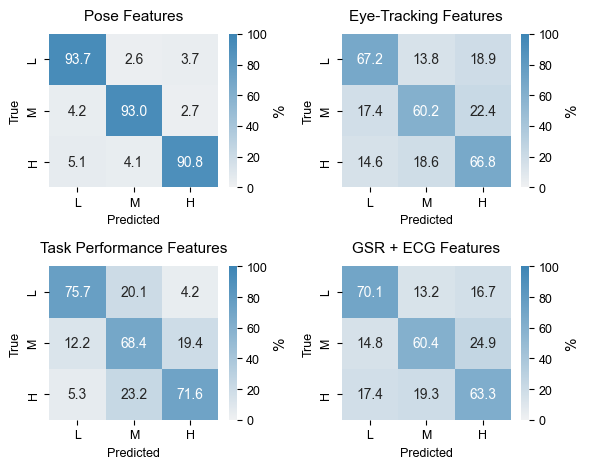

Saved to figures/confusion_matrix_grid_participant_none_noderiv.png


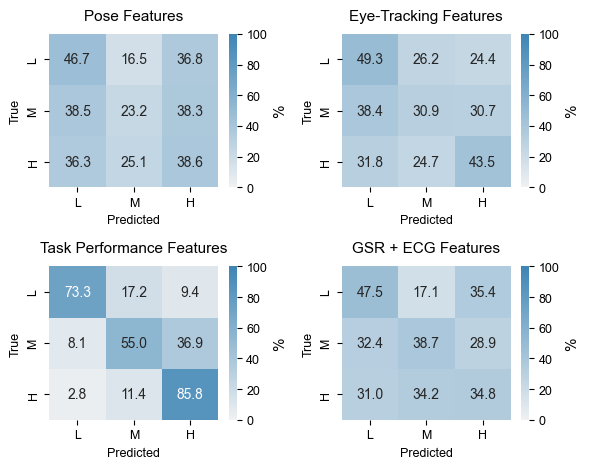

In [5]:
# Example 1: Plot confusion matrices for 4 feature groups
fig = plot_confusion_matrix_grid(
    feature_list=['pose', 'eye', 'performance', 'gsr_ecg'],
    strategy='random',
    pose_variant='procrustes_global_all_backward',
    suffix='_backward',
    save_path='figures/confusion_matrix_grid_random_backward.png'
)
plt.show()

# Example 2: Plot confusion matrices for 4 feature groups
fig = plot_confusion_matrix_grid(
    feature_list=['pose', 'eye', 'performance', 'gsr_ecg'],
    strategy='participant',
    pose_variant='procrustes_global_all_none_noderiv',
    suffix='_none_noderiv',
    save_path='figures/confusion_matrix_grid_participant_none_noderiv.png'
)
plt.show()


## Note: Confusion Matrices for LOPO and Participant-Specific Strategies

**Current Limitation**: Confusion matrices are only available for `random_split` and `participant_split` strategies.

The `lopo` and `participant_specific` strategies currently do **not** save confusion matrices to their JSON output files. This is because:

1. **LOPO Strategy**: Tests on each participant individually (~45 separate test sets), but only saves aggregated metrics (accuracy, F1, kappa) per participant in the `participant_results` field. Per-participant confusion matrices are not saved.

2. **Participant-Specific Strategy**: Focuses on learning curves showing how accuracy improves with training data. Individual confusion matrices are not saved for each participant at each training size.

### To Enable Confusion Matrices for These Strategies:

The modeling scripts (`utils/pipeline_utils.py`) would need to be modified to:

1. **For LOPO** (lines 1454-1490 in `run_lopo_model`):
   - Compute confusion matrix for each participant fold
   - Save per-participant confusion matrices in the JSON output
   - Average across all participants when displaying

2. **For Participant-Specific** (similar location in `run_participant_specific_model`):
   - Compute confusion matrix for each participant at the largest training size
   - Save per-participant confusion matrices
   - Average across participants

### Current Workaround:

For now, use the `random_split` or `participant_split` strategies if you need confusion matrix visualizations. These strategies aggregate predictions across all test samples and save a single averaged confusion matrix.

## Figure 2: Accuracy Bar Plot

Shows average accuracy for all model combinations.

In [6]:
def generate_all_model_combinations(feature_groups):
    """
    Generate all possible combinations of feature groups.
    
    Args:
        feature_groups: List of feature group names
    
    Returns:
        List of tuples representing combinations
    """
    all_combos = []
    for r in range(1, len(feature_groups) + 1):
        all_combos.extend(combinations(feature_groups, r))
    return all_combos


def discover_available_models(strategy, pose_variant, suffix='_backward'):
    """
    Auto-discover all available model JSON files in the specified directory.
    
    Args:
        strategy: CV strategy to use
        pose_variant: Pose variant directory name
        suffix: Filename suffix
    
    Returns:
        List of model names (without suffix)
    """
    strategy_dir = MODEL_OUTPUT_DIR / STRATEGIES[strategy]
    if not strategy_dir.exists():
        return []
    
    # Look in subdirectory
    variant_dir = strategy_dir / pose_variant
    if not variant_dir.exists():
        # Try direct in strategy dir as fallback
        variant_dir = strategy_dir
    
    # Find all JSON files matching the pattern
    available = []
    for json_file in variant_dir.glob(f"*{suffix}.json"):
        # Extract model name by removing suffix
        model_name = json_file.stem
        if model_name.endswith(suffix.lstrip('_')):
            model_name = model_name[:-(len(suffix.lstrip('_'))+1)]
        
        # Skip settings file
        if model_name != 'settings':
            available.append(model_name)
    
    return sorted(available)


def plot_accuracy_bars(feature_groups=None, strategy='random', pose_variant='procrustes_global_all_backward',
                       suffix='_backward', use_balanced=True, figsize=None, save_path=None,
                       use_upset_style=True):
    """
    Plot bar chart of accuracy for all model combinations.
    
    Args:
        feature_groups: List of feature group names, or None to auto-discover all available models
        strategy: CV strategy to use
        pose_variant: Pose variant directory name
        suffix: Filename suffix  
        use_balanced: If True, use balanced accuracy; otherwise use regular accuracy
        figsize: Figure size (auto-calculated if None)
        save_path: Path to save figure
        use_upset_style: If True, use dots and lines instead of text labels (matches reference figure)
    
    Returns:
        matplotlib figure
    """
    # Auto-discover if feature_groups is None or empty
    if feature_groups is None or len(feature_groups) == 0:
        print(f"Auto-discovering models in {STRATEGIES[strategy]}/{pose_variant}/...")
        discovered = discover_available_models(strategy, pose_variant, suffix)
        print(f"Found {len(discovered)} models: {discovered}")
        feature_groups = discovered
    
    if not feature_groups:
        print("No models found!")
        return None
    
    results = []
    
    for feature_name in feature_groups:
        metrics = get_accuracy_metrics(strategy, pose_variant, feature_name, suffix)
        
        if metrics is not None:
            if use_balanced:
                acc_mean = metrics['bal_acc_mean']
                acc_std = metrics['bal_acc_std']
            else:
                acc_mean = metrics['acc_mean']
                acc_std = metrics['acc_std']
            
            # Try to get nice display name, fallback to feature_name
            display_name = FEATURE_GROUPS.get(feature_name, feature_name.replace('_', ' ').title())
            
            results.append({
                'model': display_name,
                'feature_name': feature_name,
                'accuracy': acc_mean * 100,  # Convert to percentage
                'error': acc_std * 100
            })
    
    if not results:
        print("No results found!")
        return None
    
    # Create DataFrame and sort by accuracy
    df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
    
    # Define main feature categories for upset-style plot
    main_features = ['pose', 'performance', 'eye', 'gsr', 'ecg']
    feature_labels = {
        'pose': 'Pose',
        'performance': 'Performance', 
        'eye': 'Eye-Tracking',
        'gsr': 'GSR',
        'ecg': 'ECG'
    }
    
    # Auto-calculate figure size if not provided
    if figsize is None:
        if use_upset_style:
            figsize = (max(10, len(df) * 0.4), 4)
        else:
            figsize = (10, 4)
    
    # Create plot with different layout for upset style
    if use_upset_style:
        fig = plt.figure(figsize=figsize)
        
        # Split figure: top for bars, bottom for feature indicators
        gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
        ax_bars = fig.add_subplot(gs[0])
        ax_features = fig.add_subplot(gs[1], sharex=ax_bars)
        
        # Plot bars
        x_pos = np.arange(len(df))

        # Assign colors: single-feature models get their color, combinations get lighter blue
        colors = []
        for _, row in df.iterrows():
            feature_name = row['feature_name']
            # Count underscores to detect combination models (e.g., 'gsr_ecg', 'pose_eye')
            # Also check for 'all_modalities'
            if '_' in feature_name and feature_name not in COLORS:
                colors.append(COMBO_COLOR)  # Combination model
            else:
                colors.append(COLORS.get(feature_name, COMBO_COLOR))  # Single feature
        
        ax_bars.bar(x_pos, df['accuracy'], yerr=df['error'], 
                    color=colors, alpha=0.8, capsize=5, 
                    error_kw={'linewidth': 1.5})
        
        # Add percentage labels on top of bars
        for i, (idx, row) in enumerate(df.iterrows()):
            height = row['accuracy']
            ax_bars.text(i, height + row['error'] + 1, f"{height:.1f}%",
                        ha='center', va='bottom', fontsize=7)
        
        # Formatting bars
        ax_bars.set_ylabel('Accuracy (%)' if not use_balanced else 'Balanced Accuracy (%)', fontsize=9)
        ax_bars.set_ylim(0, 105)
        ax_bars.grid(axis='y', alpha=0.3, linestyle='--')
        ax_bars.set_axisbelow(True)
        ax_bars.set_xticks([])
        
        strategy_title = STRATEGIES[strategy].replace('_', ' ').title()
        if strategy == 'lopo':
            strategy_title = 'Leave-One-Participant-Out'
        ax_bars.set_title(f'{strategy_title} Models', fontsize=10, pad=15)
        
        # Plot feature indicators (upset style)
        ax_features.set_ylim(-0.5, len(main_features) - 0.5)
        ax_features.set_xlim(-0.5, len(df) - 0.5)
        ax_features.invert_yaxis()
        
        # Add feature labels on left
        ax_features.set_yticks(range(len(main_features)))
        ax_features.set_yticklabels([feature_labels.get(f, f) for f in main_features], fontsize=9)
        
        # Draw dots and lines for each model
        for i, (idx, row) in enumerate(df.iterrows()):
            model_name = row['feature_name']
            
            # Check which features are included
            included_features = []
            for j, feature in enumerate(main_features):
                # Check if feature is in model name
                if feature in model_name or (feature == 'performance' and 'perf' in model_name):
                    included_features.append(j)
            
            # Draw dots for included features
            for j in included_features:
                ax_features.scatter(i, j, s=35, color='black', zorder=3)
            
            # Draw connecting line if multiple features
            if len(included_features) > 1:
                y_min = min(included_features)
                y_max = max(included_features)
                ax_features.plot([i, i], [y_min, y_max], 'k-', linewidth=2, zorder=2)
        
        # Remove x-axis labels and ticks from feature panel
        ax_features.set_xticks([])
        ax_features.set_xlabel('')
        ax_features.spines['top'].set_visible(False)
        ax_features.spines['right'].set_visible(False)
        ax_features.spines['bottom'].set_visible(False)
        
        # Add grid lines between features
        for i in range(len(main_features) - 1):
            ax_features.axhline(i + 0.5, color='gray', linewidth=0.5, alpha=0.3)
        
    else:
        # Original style with text labels
        fig, ax = plt.subplots(figsize=figsize)
        
        x_pos = np.arange(len(df))
        # Assign colors: single-feature models get their color, combinations get lighter blue
        colors = []
        for _, row in df.iterrows():
            feature_name = row['feature_name']
            if '_' in feature_name and feature_name not in COLORS:
                colors.append(COMBO_COLOR)  # Combination model
            else:
                colors.append(COLORS.get(feature_name, COMBO_COLOR))  # Single feature
        
        ax.bar(x_pos, df['accuracy'], yerr=df['error'], 
               color=colors, alpha=0.8, capsize=5, 
               error_kw={'linewidth': 1.5})
        
        for i, (idx, row) in enumerate(df.iterrows()):
            height = row['accuracy']
            ax.text(i, height + row['error'] + 1, f"{height:.1f}%",
                   ha='center', va='bottom', fontsize=7)
        
        ax.set_ylabel('Accuracy (%)' if not use_balanced else 'Balanced Accuracy (%)', fontsize=9)
        ax.set_xlabel('Model', fontsize=9)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(df['model'], rotation=45, ha='right')
        ax.set_ylim(0, 105)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        strategy_title = STRATEGIES[strategy].replace('_', ' ').title()
        if strategy == 'lopo':
            strategy_title = 'Leave-One-Participant-Out'
        ax.set_title(f'{strategy_title} Models', fontsize=10, pad=15)
    
    #no box border around plot
    for spine in ax_bars.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    return fig

### Example: Bar Plot for All Models

Auto-discovering models in random_split/procrustes_global_all_backward/...
Found 31 models: ['all_modalities', 'ecg', 'eye', 'eye_ecg', 'eye_gsr', 'eye_gsr_ecg', 'gsr', 'gsr_ecg', 'perf_ecg', 'perf_eye', 'perf_eye_ecg', 'perf_eye_gsr', 'perf_eye_gsr_ecg', 'perf_gsr', 'perf_gsr_ecg', 'performance', 'pose', 'pose_ecg', 'pose_eye', 'pose_eye_ecg', 'pose_eye_gsr', 'pose_eye_gsr_ecg', 'pose_gsr', 'pose_gsr_ecg', 'pose_perf', 'pose_perf_ecg', 'pose_perf_eye', 'pose_perf_eye_ecg', 'pose_perf_eye_gsr', 'pose_perf_gsr', 'pose_perf_gsr_ecg']
Saved to figures/accuracy_random_procrustes_global_all_backward.png


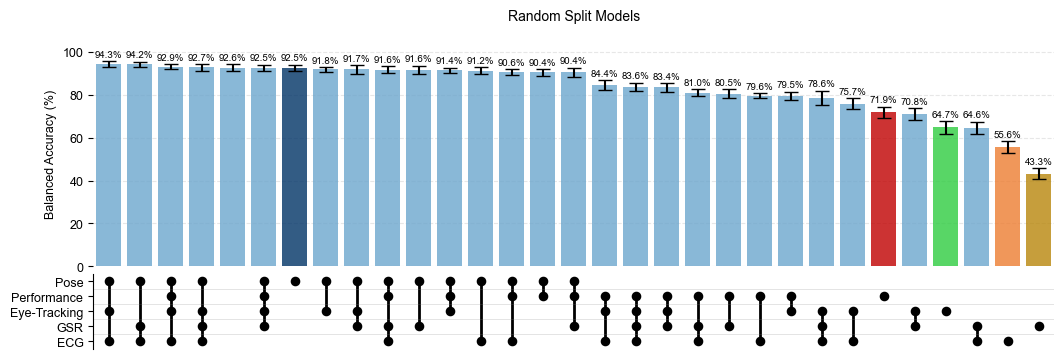

Auto-discovering models in lopo/procrustes_global_all_backward_noderiv_zscore_hyp_pca/...
Found 0 models: []
No models found!
Auto-discovering models in participant_specific/procrustes_global_all_backward/...
Found 31 models: ['all_modalities', 'ecg', 'eye', 'eye_ecg', 'eye_gsr', 'eye_gsr_ecg', 'gsr', 'gsr_ecg', 'perf_ecg', 'perf_eye', 'perf_eye_ecg', 'perf_eye_gsr', 'perf_eye_gsr_ecg', 'perf_gsr', 'perf_gsr_ecg', 'performance', 'pose', 'pose_ecg', 'pose_eye', 'pose_eye_ecg', 'pose_eye_gsr', 'pose_eye_gsr_ecg', 'pose_gsr', 'pose_gsr_ecg', 'pose_perf', 'pose_perf_ecg', 'pose_perf_eye', 'pose_perf_eye_ecg', 'pose_perf_eye_gsr', 'pose_perf_gsr', 'pose_perf_gsr_ecg']
Saved to figures/accuracy_specific_procrustes_global_all_backward.png


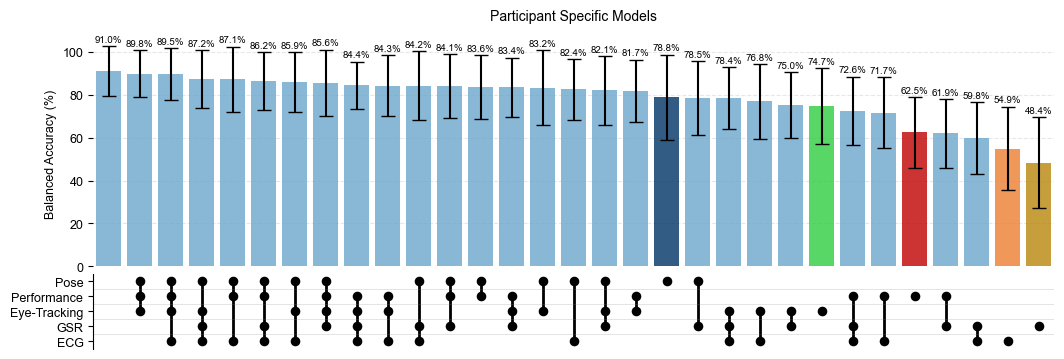

In [12]:
# Example 1: Plot with upset-style indicators (matches reference figure)
fig = plot_accuracy_bars(
    feature_groups=None,  # Auto-discover all models
    strategy='random',
    pose_variant='procrustes_global_all_backward',
    suffix='_backward',
    use_balanced=True,
    use_upset_style=True,  # Use dots and lines (default)
    save_path='figures/accuracy_random_procrustes_global_all_backward.png'
)
plt.show()

# Example 2: Plot with upset-style indicators (matches reference figure)    
fig = plot_accuracy_bars(
    feature_groups=None,  # Auto-discover all models
    strategy='lopo',
    pose_variant='procrustes_global_all_backward_noderiv_zscore_hyp_pca',
    suffix='_zscore',
    use_balanced=True,
    use_upset_style=True,  # Use dots and lines (default)
    save_path='figures/accuracy_lopo_procrustes_global_all_backward_noderiv_zscore_hyp_pca.png'
)
plt.show()

# Example 3: Plot with upset-style indicators (matches reference figure)
fig = plot_accuracy_bars(
    feature_groups=None,  # Auto-discover all models
    strategy='specific',
    pose_variant='procrustes_global_all_backward',
    suffix='_backward',
    use_balanced=True,
    use_upset_style=True,  # Use dots and lines (default)
    save_path='figures/accuracy_specific_procrustes_global_all_backward.png'
)
plt.show()

## Figure 3: Learning Curves

Time series plots showing accuracy vs number of training windows for participant-specific models.

In [8]:
def plot_learning_curves(feature_list, pose_variant='procrustes_global_all_backward',
                         suffix='_backward', figsize=(7, 4.5), save_path=None, 
                         show_shaded_error=True, min_windows=2):
    """
    Plot learning curves for multiple feature groups.
    
    Args:
        feature_list: List of feature names
        pose_variant: Pose variant directory name
        suffix: Filename suffix
        figsize: Figure size tuple
        save_path: Path to save figure
        show_shaded_error: If True, show shaded error bands; otherwise use error bars
        min_windows: Minimum training windows to plot (default 2, as 1 window is unreliable)
    
    Note:
        X-axis represents training windows PER CONDITION (e.g., 3 means 3 windows from L, M, and H each = 9 total)
        Windows are 60s with 50% overlap, so N windows = (0.5 + 0.5*N) minutes of data
        Top axis shows test windows available (total 15 - training - 1 buffer = 14 - training)
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    all_x_values = None
    for feature_name in feature_list:
        df = load_learning_curve(pose_variant, feature_name, suffix)
        if df is None or len(df) == 0:
            print(f"No learning curve data for {feature_name}")
            continue
        
        # Filter to only include windows >= min_windows
        df = df[df['train_size'] >= min_windows].copy()
        
        if len(df) == 0:
            print(f"No data for {feature_name} with min_windows={min_windows}")
            continue
        
        x = df['train_size'].values
        y = df['test_bal_acc_mean'].values * 100
        error = df['test_bal_acc_std'].values * 100
        
        if all_x_values is None:
            all_x_values = x
        
        color = COLORS.get(feature_name, '#4472C4')
        label = FEATURE_GROUPS.get(feature_name, feature_name)
        
        ax.plot(x, y, marker='o', linewidth=2, markersize=6, 
                color=color, label=label, alpha=0.9)
        
        if show_shaded_error:
            ax.fill_between(x, y - error, y + error, color=color, alpha=0.2)
        else:
            ax.errorbar(x, y, yerr=error, fmt='none', color=color, alpha=0.5, capsize=3)
    
    # Formatting
    ax.set_xlabel('Training windows per condition', fontsize=10)
    ax.set_ylabel('Balanced Accuracy (%)', fontsize=10)
    ax.set_ylim(30, 100)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.legend(loc='lower right', framealpha=0.9, fontsize=9)
    
    # Set x-axis limits and ticks with minutes in parentheses
    if all_x_values is not None:
        ax.set_xlim(all_x_values[0] - 0.5, all_x_values[-1] + 0.5)
        ax.set_xticks(all_x_values)
        
        # Calculate minutes for each window count (60s windows with 50% overlap)
        # N windows = 0.5 + 0.5*N minutes
        x_labels = []
        for n_win in all_x_values:
            minutes = 0.5 + 0.5 * n_win
            x_labels.append(f'{int(n_win)}\n({minutes:.1f} min)')
        ax.set_xticklabels(x_labels, fontsize=8)
    
    # Top x-axis showing test windows (accounting for 1 buffer window)
    # Total ~15 windows per condition, so test = 15 - training - 1 (buffer)
    if all_x_values is not None:
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(all_x_values)
        
        # Calculate test windows: 14 - training (14 = 15 total - 1 buffer)
        test_windows = [14 - int(train) for train in all_x_values]
        ax2.set_xticklabels([str(t) for t in test_windows])
        ax2.set_xlabel('Test windows per condition (after buffer)', fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    return fig


### Example: Learning Curves for All Features

Saved to figures/learning_curves.png


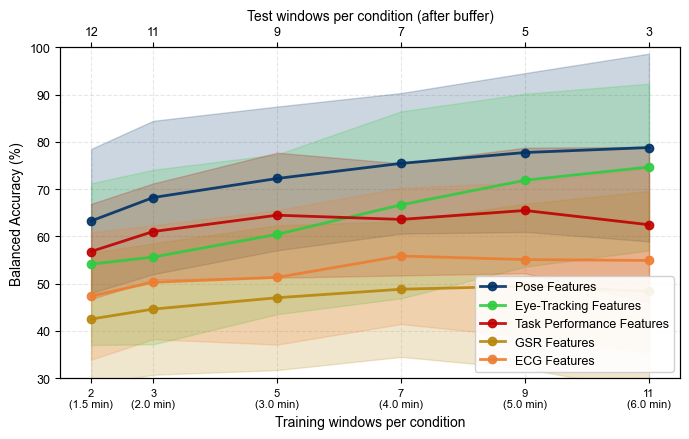

In [9]:
# Example: Plot learning curves for all feature groups
# NOTE: Learning curves use participant_specific results
# Starts at 2 windows (skips 1 window as unreliable)
fig = plot_learning_curves(
    feature_list=['pose', 'eye', 'performance', 'gsr', 'ecg'],
    pose_variant='procrustes_global_all_backward',
    suffix='_backward',
    show_shaded_error=True,
    min_windows=2,  # Start at 2 windows (1 window is unreliable)
    save_path='figures/learning_curves.png'
)
plt.show()


## Batch Generation

Generate all three figure types at once.

In [10]:
def generate_all_figures(feature_list, strategy='random', 
                         pose_variant='procrustes_global_all_backward',
                         suffix='_backward', output_dir='figures'):
    """
    Generate all three figure types and save them.
    
    Args:
        feature_list: List of feature names
        strategy: CV strategy for confusion matrices and bar plots
        pose_variant: Pose variant directory
        suffix: Filename suffix
        output_dir: Directory to save figures
    """
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True, parents=True)
    
    print(f"Generating figures for {len(feature_list)} feature groups...")
    print(f"Strategy: {strategy}")
    print(f"Pose variant: {pose_variant}")
    print()
    
    # Figure 1: Confusion Matrix Grid
    print("[1/3] Generating confusion matrix grid...")
    try:
        fig1 = plot_confusion_matrix_grid(
            feature_list=feature_list,
            strategy=strategy,
            pose_variant=pose_variant,
            suffix=suffix,
            save_path=output_path / f'confusion_matrix_grid_{strategy}.png'
        )
        plt.close(fig1)
        print("  ✓ Confusion matrix grid saved")
    except Exception as e:
        print(f"  ✗ Error: {e}")
    
    print()
    
    # Figure 2: Accuracy Bar Plot
    print("[2/3] Generating accuracy bar plot...")
    try:
        fig2 = plot_accuracy_bars(
            feature_groups=feature_list,
            strategy=strategy,
            pose_variant=pose_variant,
            suffix=suffix,
            use_balanced=True,
            save_path=output_path / f'accuracy_bars_{strategy}.png'
        )
        plt.close(fig2)
        print("  ✓ Accuracy bar plot saved")
    except Exception as e:
        print(f"  ✗ Error: {e}")
    
    print()
    
    # Figure 3: Learning Curves (always uses participant_specific)
    print("[3/3] Generating learning curves...")
    try:
        fig3 = plot_learning_curves(
            feature_list=feature_list,
            pose_variant=pose_variant,
            suffix=suffix,
            show_shaded_error=True,
            min_windows=2,  # Start at 2 windows (1 window is unreliable)
            save_path=output_path / 'learning_curves.png'
        )
        plt.close(fig3)
        print("  ✓ Learning curves saved")
    except Exception as e:
        print(f"  ✗ Error: {e}")
    
    print()
    print(f"All figures saved to {output_path}/")

### Generate All Figures

In [11]:
# Generate all three figure types
# NOTE: Adjust these parameters to match your data structure
generate_all_figures(
    feature_list=['pose', 'eye', 'performance', 'gsr'],
    strategy='random',
    pose_variant='procrustes_global_all_none_noderiv',
    suffix='_none_noderiv',
    output_dir='figures'
)

Generating figures for 4 feature groups...
Strategy: random
Pose variant: procrustes_global_all_none_noderiv

[1/3] Generating confusion matrix grid...
Saved to figures/confusion_matrix_grid_random.png
  ✓ Confusion matrix grid saved

[2/3] Generating accuracy bar plot...
Saved to figures/accuracy_bars_random.png
  ✓ Accuracy bar plot saved

[3/3] Generating learning curves...
No learning curve data for pose
No learning curve data for eye
No learning curve data for performance
No learning curve data for gsr
Saved to figures/learning_curves.png
  ✓ Learning curves saved

All figures saved to figures/
